[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/FairSense/blob/main/docs/notebooks/demo-regression.ipynb)

## Demo: Fairness on regression problems

In [1]:
# !pip install -e fairsense

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deel.fairsense.data_management.factory import from_numpy, from_pandas
from deel.fairsense.data_management.processing import one_hot_encode
from deel.fairsense.indices.confidence_intervals import with_confidence_intervals
from deel.fairsense.indices.cvm import cvm_indices
from deel.fairsense.indices.standard_metrics import disparate_impact
from deel.fairsense.indices.sobol import sobol_indices
from deel.fairsense.utils.dataclasses import IndicesInput, IndicesOutput
from deel.fairsense.utils.fairness_objective import y_true, squared_error, y_pred
from deel.fairsense.visualization.plots import cat_plot
from deel.fairsense.visualization.text import format_with_intervals
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

### I) Study of the intrinsic fairness of the dataset

#### data wrangling
in this notebook we will work on the boston housing dataset.

First we will start with computing some indices on the training data to see if the dataset is biased.
The first step consist of building the IndicesInput object that stores the data. As we can set the target `y_true` means that we analyse the data, but this can be set to `y_pred` if we want to analyse predictions, or `squared_error` if we want to analyse the error. This parameter can be changer afterward.

In [3]:
data = load_boston()
# construct IndicesInput object
indices_inputs = from_numpy(
    x=data.data,
    y=data.target,
    feature_names=data.feature_names,
    target=y_true,
)
indices_inputs.x.head()

C:\Users\thibaut.boissin\AppData\Local\Continuum\anaconda3\envs\global_sensitivity_analysis_fairness\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


We can then apply preprocessing such as one_hot encoding.

In [4]:
# apply one hot encoding
indices_inputs = one_hot_encode(indices_inputs, ["CHAS", "RAD"])

#### indices computation: CVM
As we have a regression problem, we use the CVM indices to compute sensitvity analysis.

We then declare the indices computation functions. The results are stored in a `indicesOuput` object. raw value can be acessed with `.values`, Please note that 0 refers to total independence and 1 refers to total dependence.

In [5]:
indices_outputs = cvm_indices(indices_inputs)
indices_outputs.values

,CVM,CVM_indep
AGE,0.237100,0.000000
B,0.000000,0.000000
CHAS,0.000000,0.000000
CRIM,0.312337,0.000000
DIS,0.521173,0.000000
INDUS,0.000000,0.001823
LSTAT,1.000000,0.062403
NOX,0.406420,0.000000
PTRATIO,0.000000,0.001002
RAD,0.000000,0.000000


We can now plot those easily using the approriate function from the `visualization` module. The two main parameters are `plot_per` and `kind`:

- plot_per (str): can be either `variable` or `index`, when set to `variable`
    there is one graph per variable, each graph showing the values of all
    indices. Respectively setting to `index` will build one graph per index,
    each showing the values for all variable.
- kind (str): kind of visualization to produce, can be one of `strip`, `swarm`,
    `box`, `violin`, `boxen`, `point`, `bar`.
    
feel free to play with it !

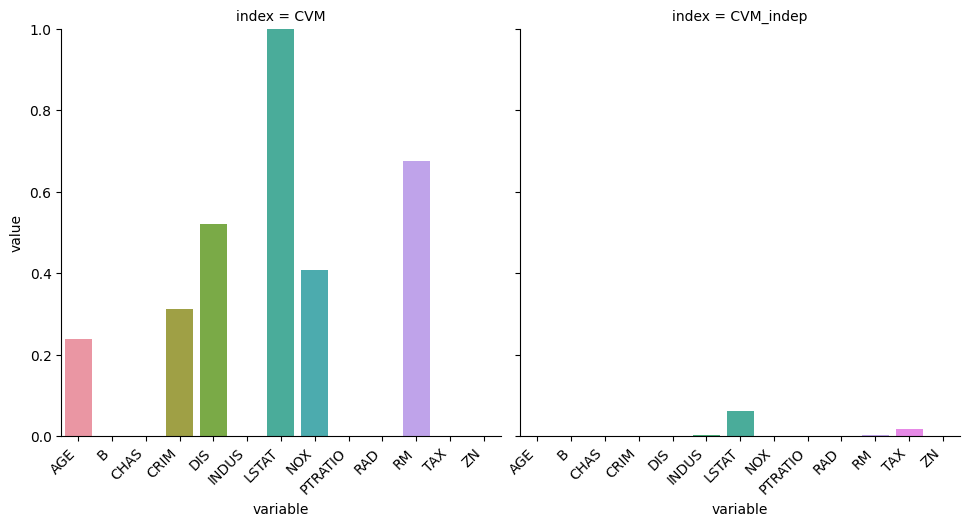

In [6]:
cat_plot(indices_outputs, plot_per="index", kind="bar")
plt.show()

#### confidence intervals

It is also possible to decorate any indice function with `with_confidence_intervals` to use bootstrapping to compute confidence intervals. We can also use the + operator to compute multiple indices simulteanously. Results with confidence intervals can be visualized either textually with `format_with_intervals` or 'graphically with `cat_plot`

In [7]:
cvm_with_ci = with_confidence_intervals(n_splits=10)(cvm_indices)
indices_outputs_ci = cvm_with_ci(indices_inputs)
format_with_intervals(indices_outputs_ci, quantile=0.05)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.55it/s]


,CVM,CVM_indep
AGE,"0.01 [0.00, 0.69]","0.00 [0.00, 0.08]"
B,"0.00 [0.00, 0.20]","0.00 [0.00, 0.09]"
CHAS,"0.00 [0.00, 0.00]","0.00 [0.00, 0.00]"
CRIM,"0.20 [0.03, 0.82]","0.00 [0.00, 0.08]"
DIS,"0.35 [0.06, 0.56]","0.00 [0.00, 0.00]"
INDUS,"0.00 [0.00, 0.00]","0.00 [0.00, 0.04]"
LSTAT,"0.71 [0.34, 1.00]","0.03 [0.00, 0.19]"
NOX,"0.00 [0.00, 0.05]","0.00 [0.00, 0.00]"
PTRATIO,"0.00 [0.00, 0.00]","0.00 [0.00, 0.00]"
RAD,"0.00 [0.00, 0.00]","0.00 [0.00, 0.00]"


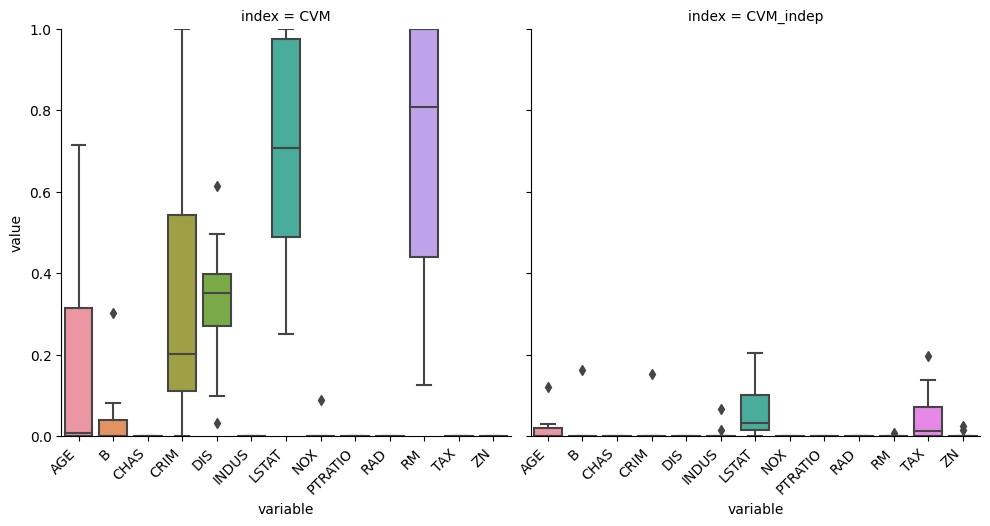

In [8]:
cat_plot(indices_outputs_ci, plot_per="index", kind="box")
plt.show()

### II) train a model and analyse it's sensitivity

#### train the model

first we will split the data and then train a basic model on it.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

similarly we build the `IndiceInput` object

In [10]:
indices_inputs_train = from_numpy(
    x=X_train,
    y=y_train,
    feature_names=data.feature_names,
)
indices_inputs_test = from_numpy(
    x=X_test,
    y=y_test,
    feature_names=data.feature_names,
)

then we train a basic model: DecisionTree. Note that this analysis can be applied to any callable that can handle numpy array as inputs.

In [11]:
model = RandomForestRegressor(250, max_depth=5, min_samples_leaf=3)
model.fit(indices_inputs_train.x, indices_inputs_train.y_true)
train_score = model.score(indices_inputs_train.x, indices_inputs_train.y_true)
val_score = model.score(indices_inputs_test.x, indices_inputs_test.y_true)
print(f"train score: {train_score}, val score {val_score}")

C:\Users\thibaut.boissin\AppData\Local\Continuum\anaconda3\envs\global_sensitivity_analysis_fairness\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


train score: 0.918553882862754, val score 0.8532209158213233


#### compute indices

we set the model and the objective

In [12]:
indices_inputs_train.model = model.predict
indices_inputs_train.objective = y_pred
indices_inputs_test.model = model.predict
indices_inputs_test.objective = y_pred

In [13]:
cvm_with_ci = with_confidence_intervals(n_splits=10)(cvm_indices)
sobol_with_ci = with_confidence_intervals(n_splits=10)(sobol_indices)
indices_outputs_train = cvm_with_ci(indices_inputs_train) + sobol_with_ci(indices_inputs_train)
format_with_intervals(indices_outputs_train, quantile=0.1)

100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.09s/it]


,CVM,CVM_indep,S,ST,S_ind,ST_ind
AGE,"0.00 [0.00, 0.30]","0.01 [0.00, 0.10]","0.17 [0.07, 0.28]","0.30 [0.14, 0.37]","0.01 [0.00, 0.03]","0.01 [0.00, 0.02]"
B,"0.00 [0.00, 0.04]","0.07 [0.00, 0.21]","0.05 [0.00, 0.22]","0.15 [0.05, 0.25]","0.00 [0.00, 0.01]","0.01 [0.00, 0.02]"
CHAS,"0.00 [0.00, 0.00]","0.00 [0.00, 0.00]","0.01 [0.00, 0.04]","0.08 [0.04, 0.25]","0.00 [0.00, 0.01]","0.01 [0.00, 0.01]"
CRIM,"0.18 [0.04, 0.50]","0.00 [0.00, 0.04]","0.21 [0.10, 0.35]","0.30 [0.21, 0.48]","0.00 [0.00, 0.01]","0.01 [0.01, 0.01]"
DIS,"0.11 [0.00, 0.38]","0.00 [0.00, 0.00]","0.14 [0.05, 0.24]","0.26 [0.11, 0.36]","0.00 [0.00, 0.03]","0.01 [0.01, 0.02]"
INDUS,"0.00 [0.00, 0.06]","0.00 [0.00, 0.02]","0.30 [0.05, 0.39]","0.42 [0.37, 0.52]","0.00 [0.00, 0.01]","0.01 [0.00, 0.02]"
LSTAT,"0.04 [0.00, 0.30]","0.00 [0.00, 0.00]","0.62 [0.47, 0.79]","0.81 [0.78, 0.86]","0.06 [0.00, 0.13]","0.11 [0.08, 0.13]"
NOX,"0.01 [0.00, 0.55]","0.00 [0.00, 0.00]","0.17 [0.02, 0.30]","0.34 [0.24, 0.43]","0.00 [0.00, 0.01]","0.01 [0.00, 0.02]"
PTRATIO,"0.00 [0.00, 0.01]","0.00 [0.00, 0.00]","0.27 [0.14, 0.50]","0.37 [0.27, 0.58]","0.03 [0.00, 0.06]","0.04 [0.02, 0.05]"
RAD,"0.00 [0.00, 0.00]","0.00 [0.00, 0.00]","0.13 [0.04, 0.21]","0.29 [0.22, 0.36]","0.00 [0.00, 0.01]","0.01 [0.00, 0.02]"


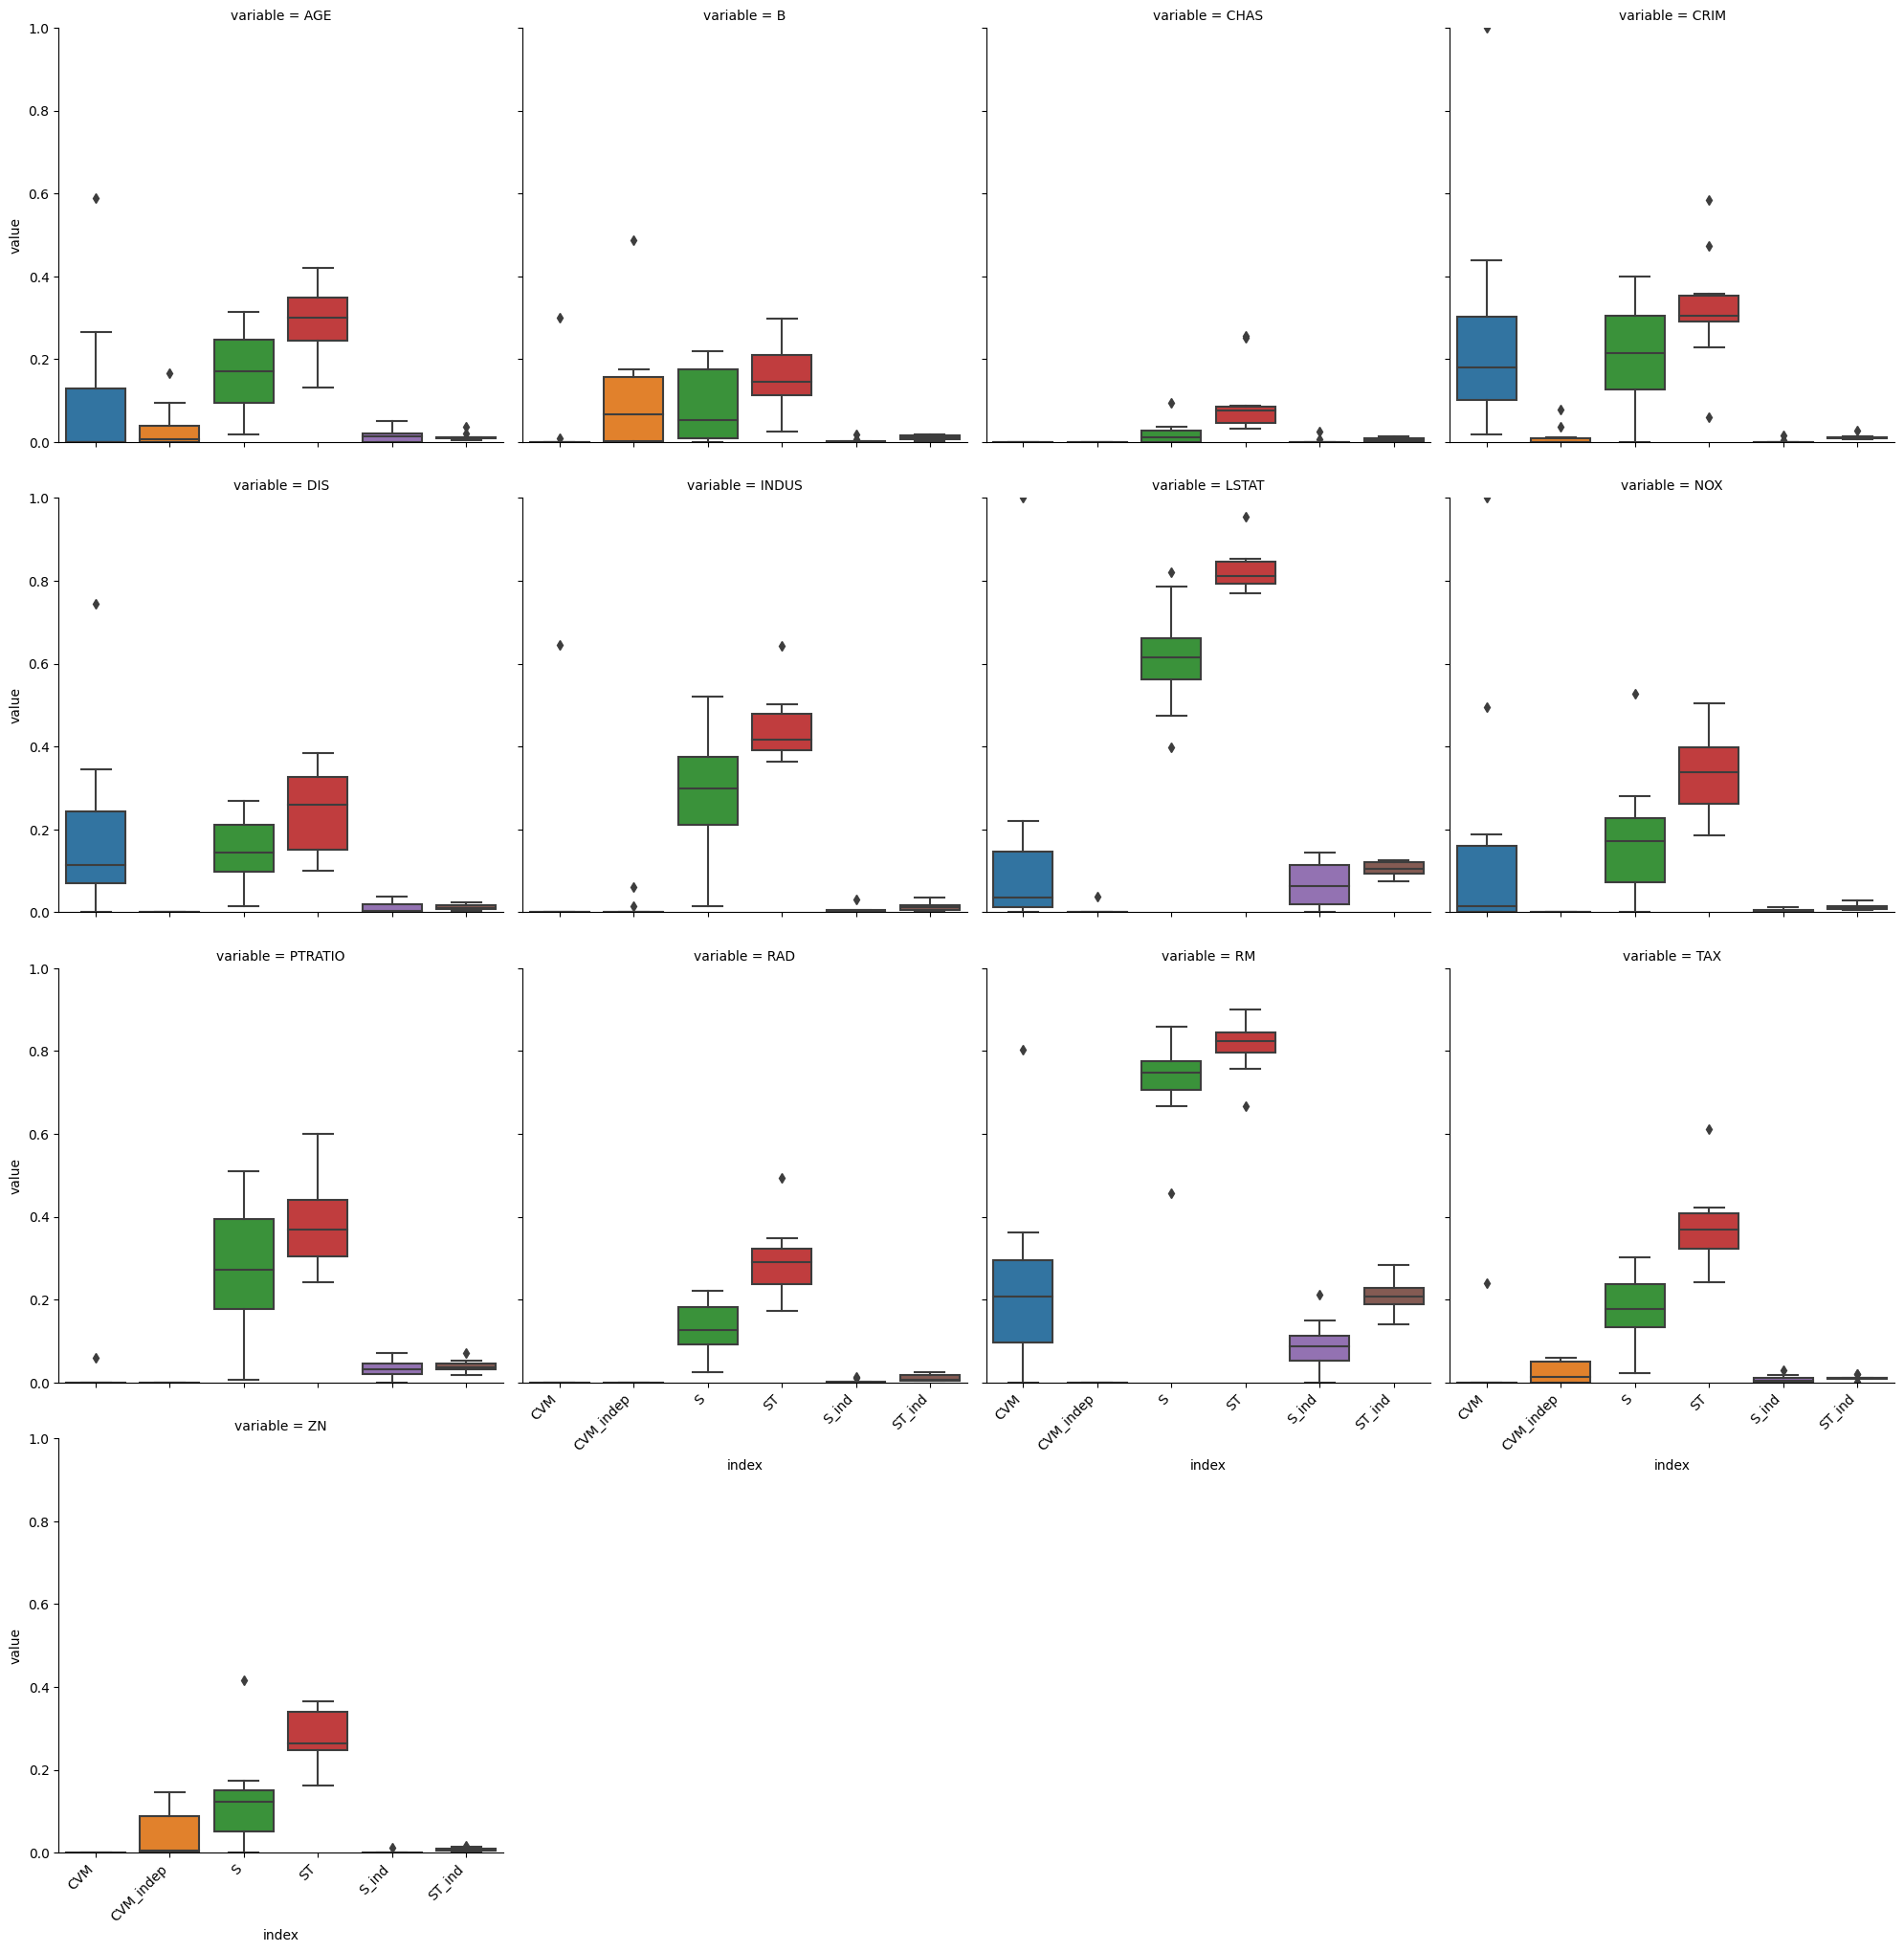

In [14]:
cat_plot(indices_outputs_train, plot_per="variable", kind="box", col_wrap=4)
plt.show()

#### compare indices from `target=y_true` with indices from `target=y_pred` 

OK, these results are interesting but we would like to compare the indices obtained with `target=y_true`.

In [15]:
merged_indices = indices_outputs_ci.runs
merged_indices[["CVM_model", "CVM_indep_model"]] = indices_outputs_train.runs[["CVM", "CVM_indep"]]
merged_indices = IndicesOutput(merged_indices[["CVM_model", "CVM", "CVM_indep_model", "CVM_indep"]])

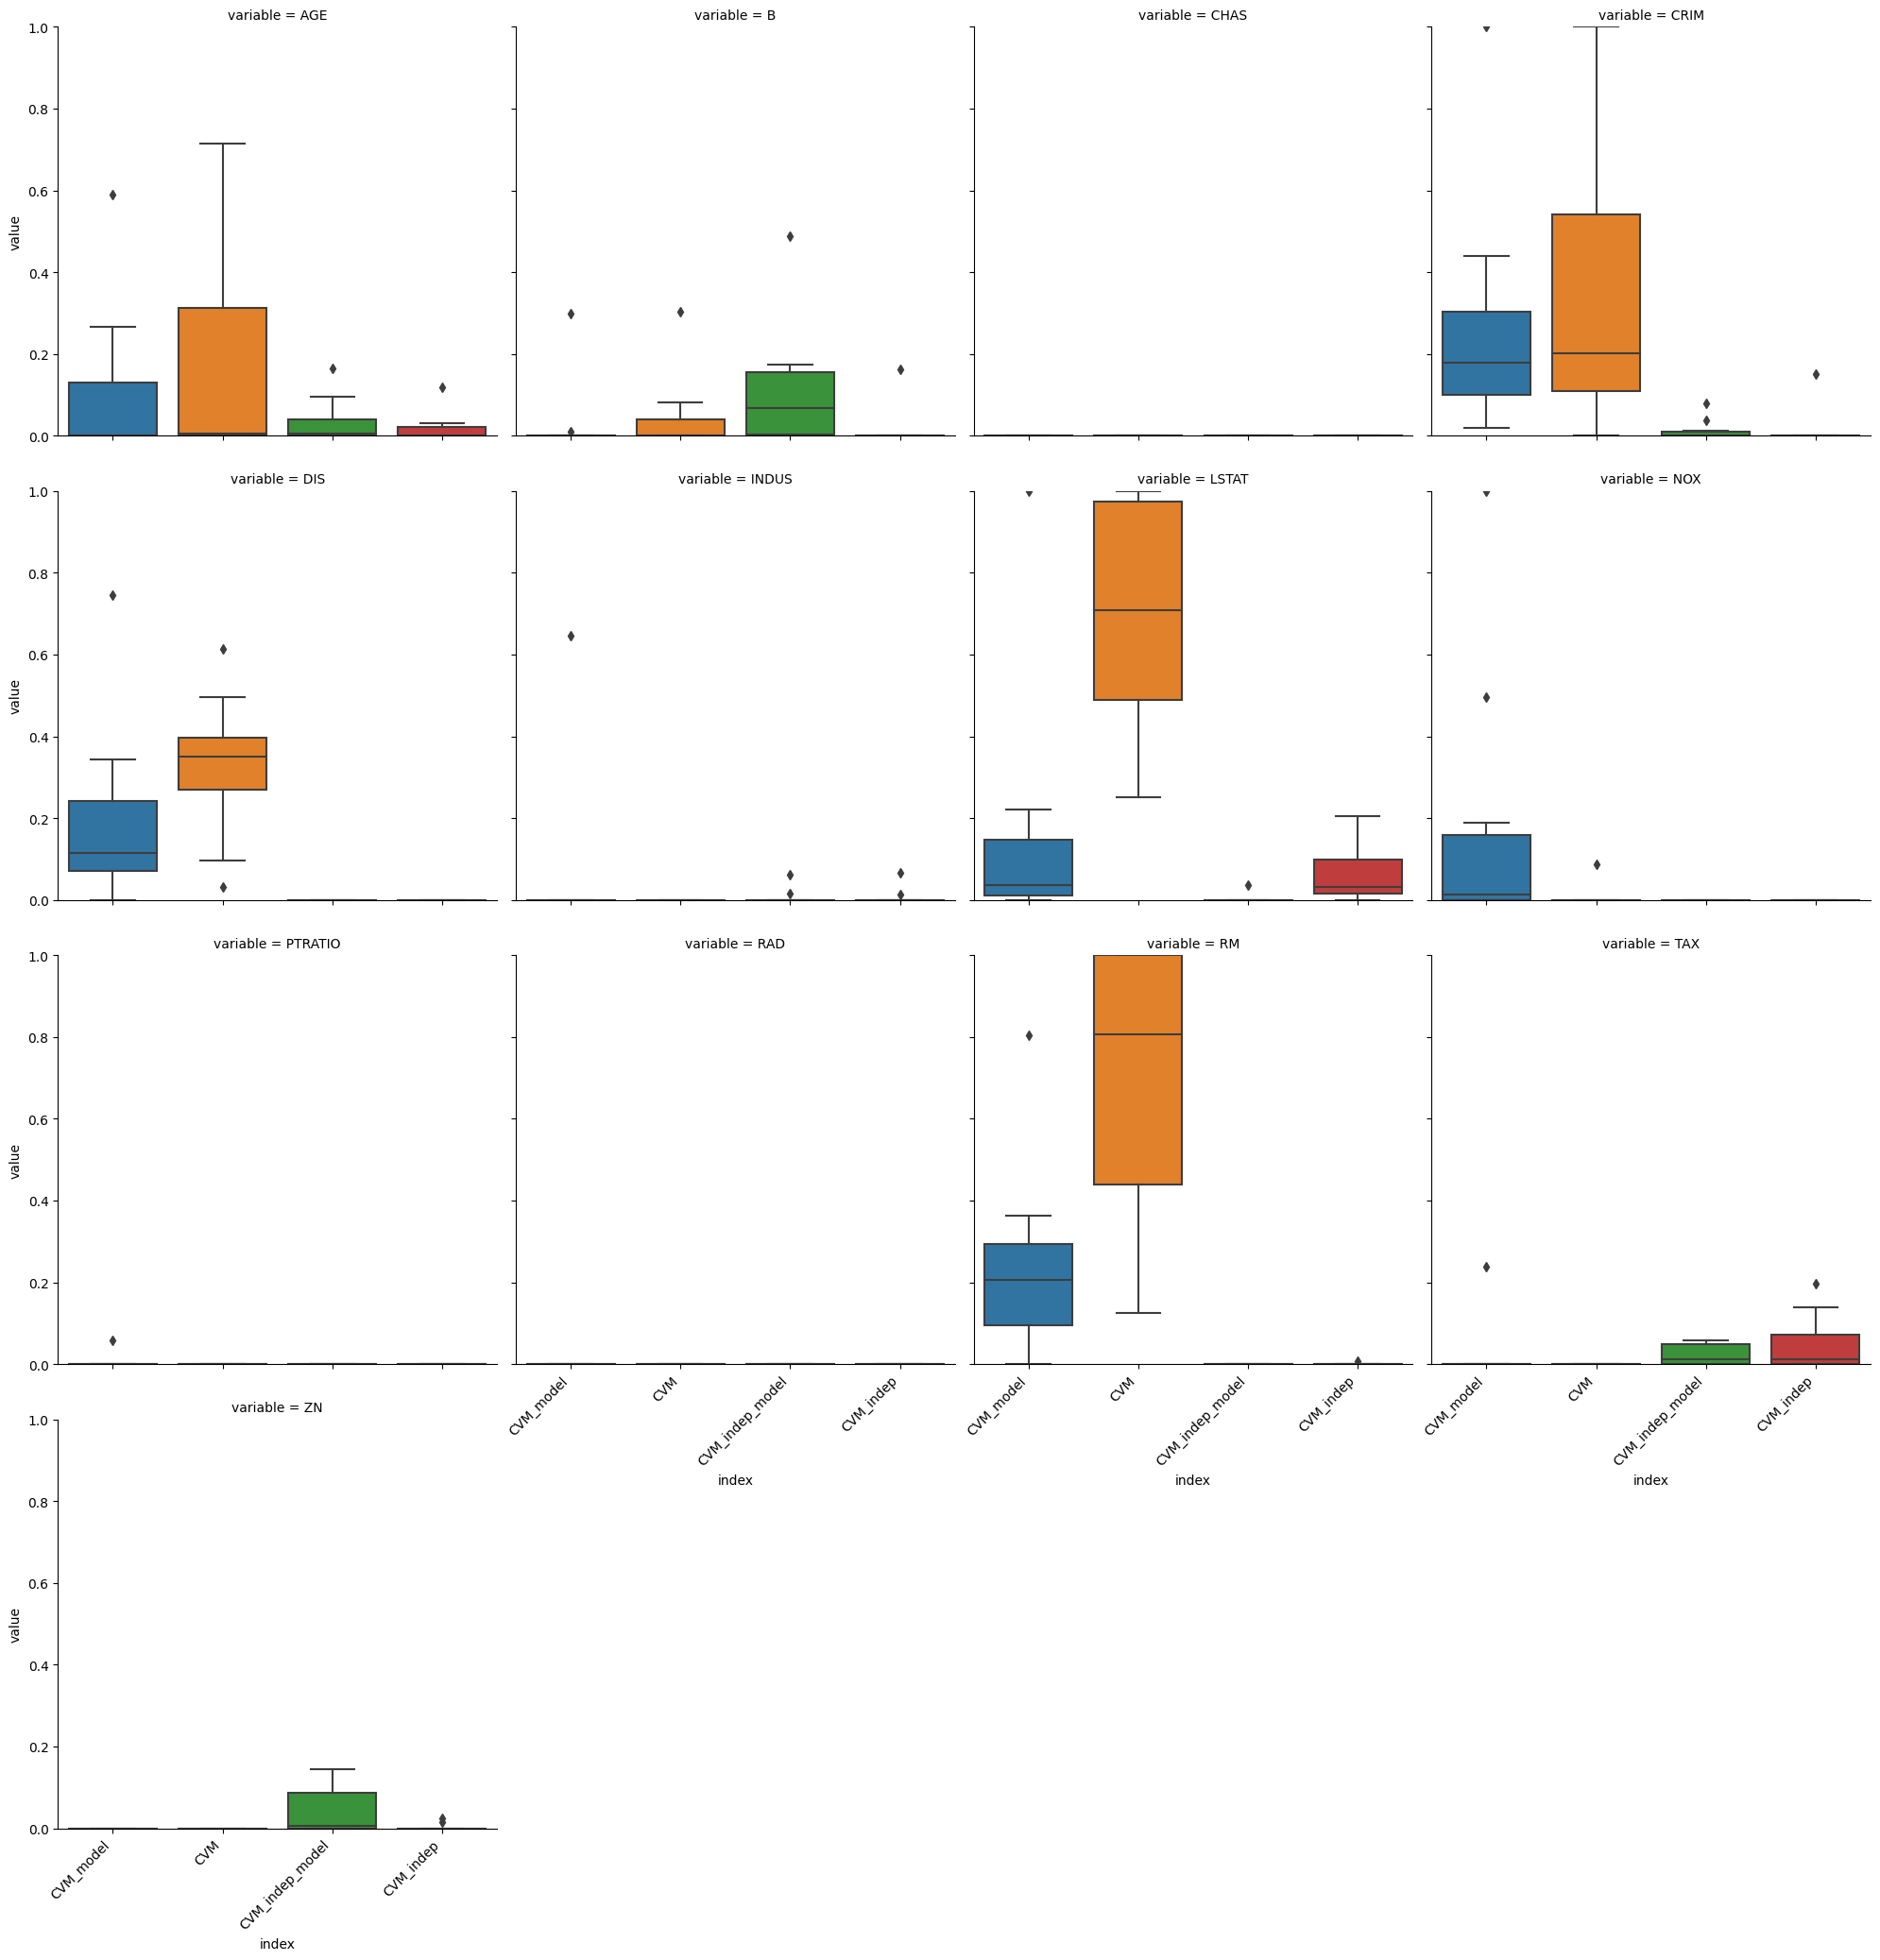

In [16]:
cat_plot(merged_indices, plot_per="variable", kind="box", col_wrap=4)
plt.show()

As we can see the model tend to increase the influence of many variables

### III) Analysis of the sensitivity of the error

Now we want to see if some variable are influent with the error of model.

In [17]:
indices_inputs_train.objective = squared_error
indices_inputs_test.objective = squared_error

In [18]:
cvm_with_ci = with_confidence_intervals(n_splits=30)(cvm_indices)
indices_outputs_error_test = cvm_with_ci(indices_inputs_test)
format_with_intervals(indices_outputs_error_test, quantile=0.1)

100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.83it/s]


,CVM,CVM_indep
AGE,"0.81 [0.44, 1.00]","0.00 [0.00, 0.00]"
B,"0.81 [0.30, 1.00]","0.00 [0.00, 0.00]"
CHAS,"0.44 [0.08, 0.44]","-0.00 [0.00, 0.00]"
CRIM,"0.62 [0.30, 1.00]","-0.00 [0.00, 0.00]"
DIS,"1.00 [0.44, 1.00]","-0.00 [0.00, 0.00]"
INDUS,"0.62 [0.43, 1.00]","-0.00 [0.00, 0.00]"
LSTAT,"0.62 [0.43, 1.00]","-0.00 [0.00, 0.00]"
NOX,"0.81 [0.44, 1.00]","-0.00 [0.00, 0.00]"
PTRATIO,"1.00 [0.44, 1.00]","-0.00 [0.00, 0.00]"
RAD,"0.44 [0.08, 1.00]","-0.00 [0.00, 0.00]"


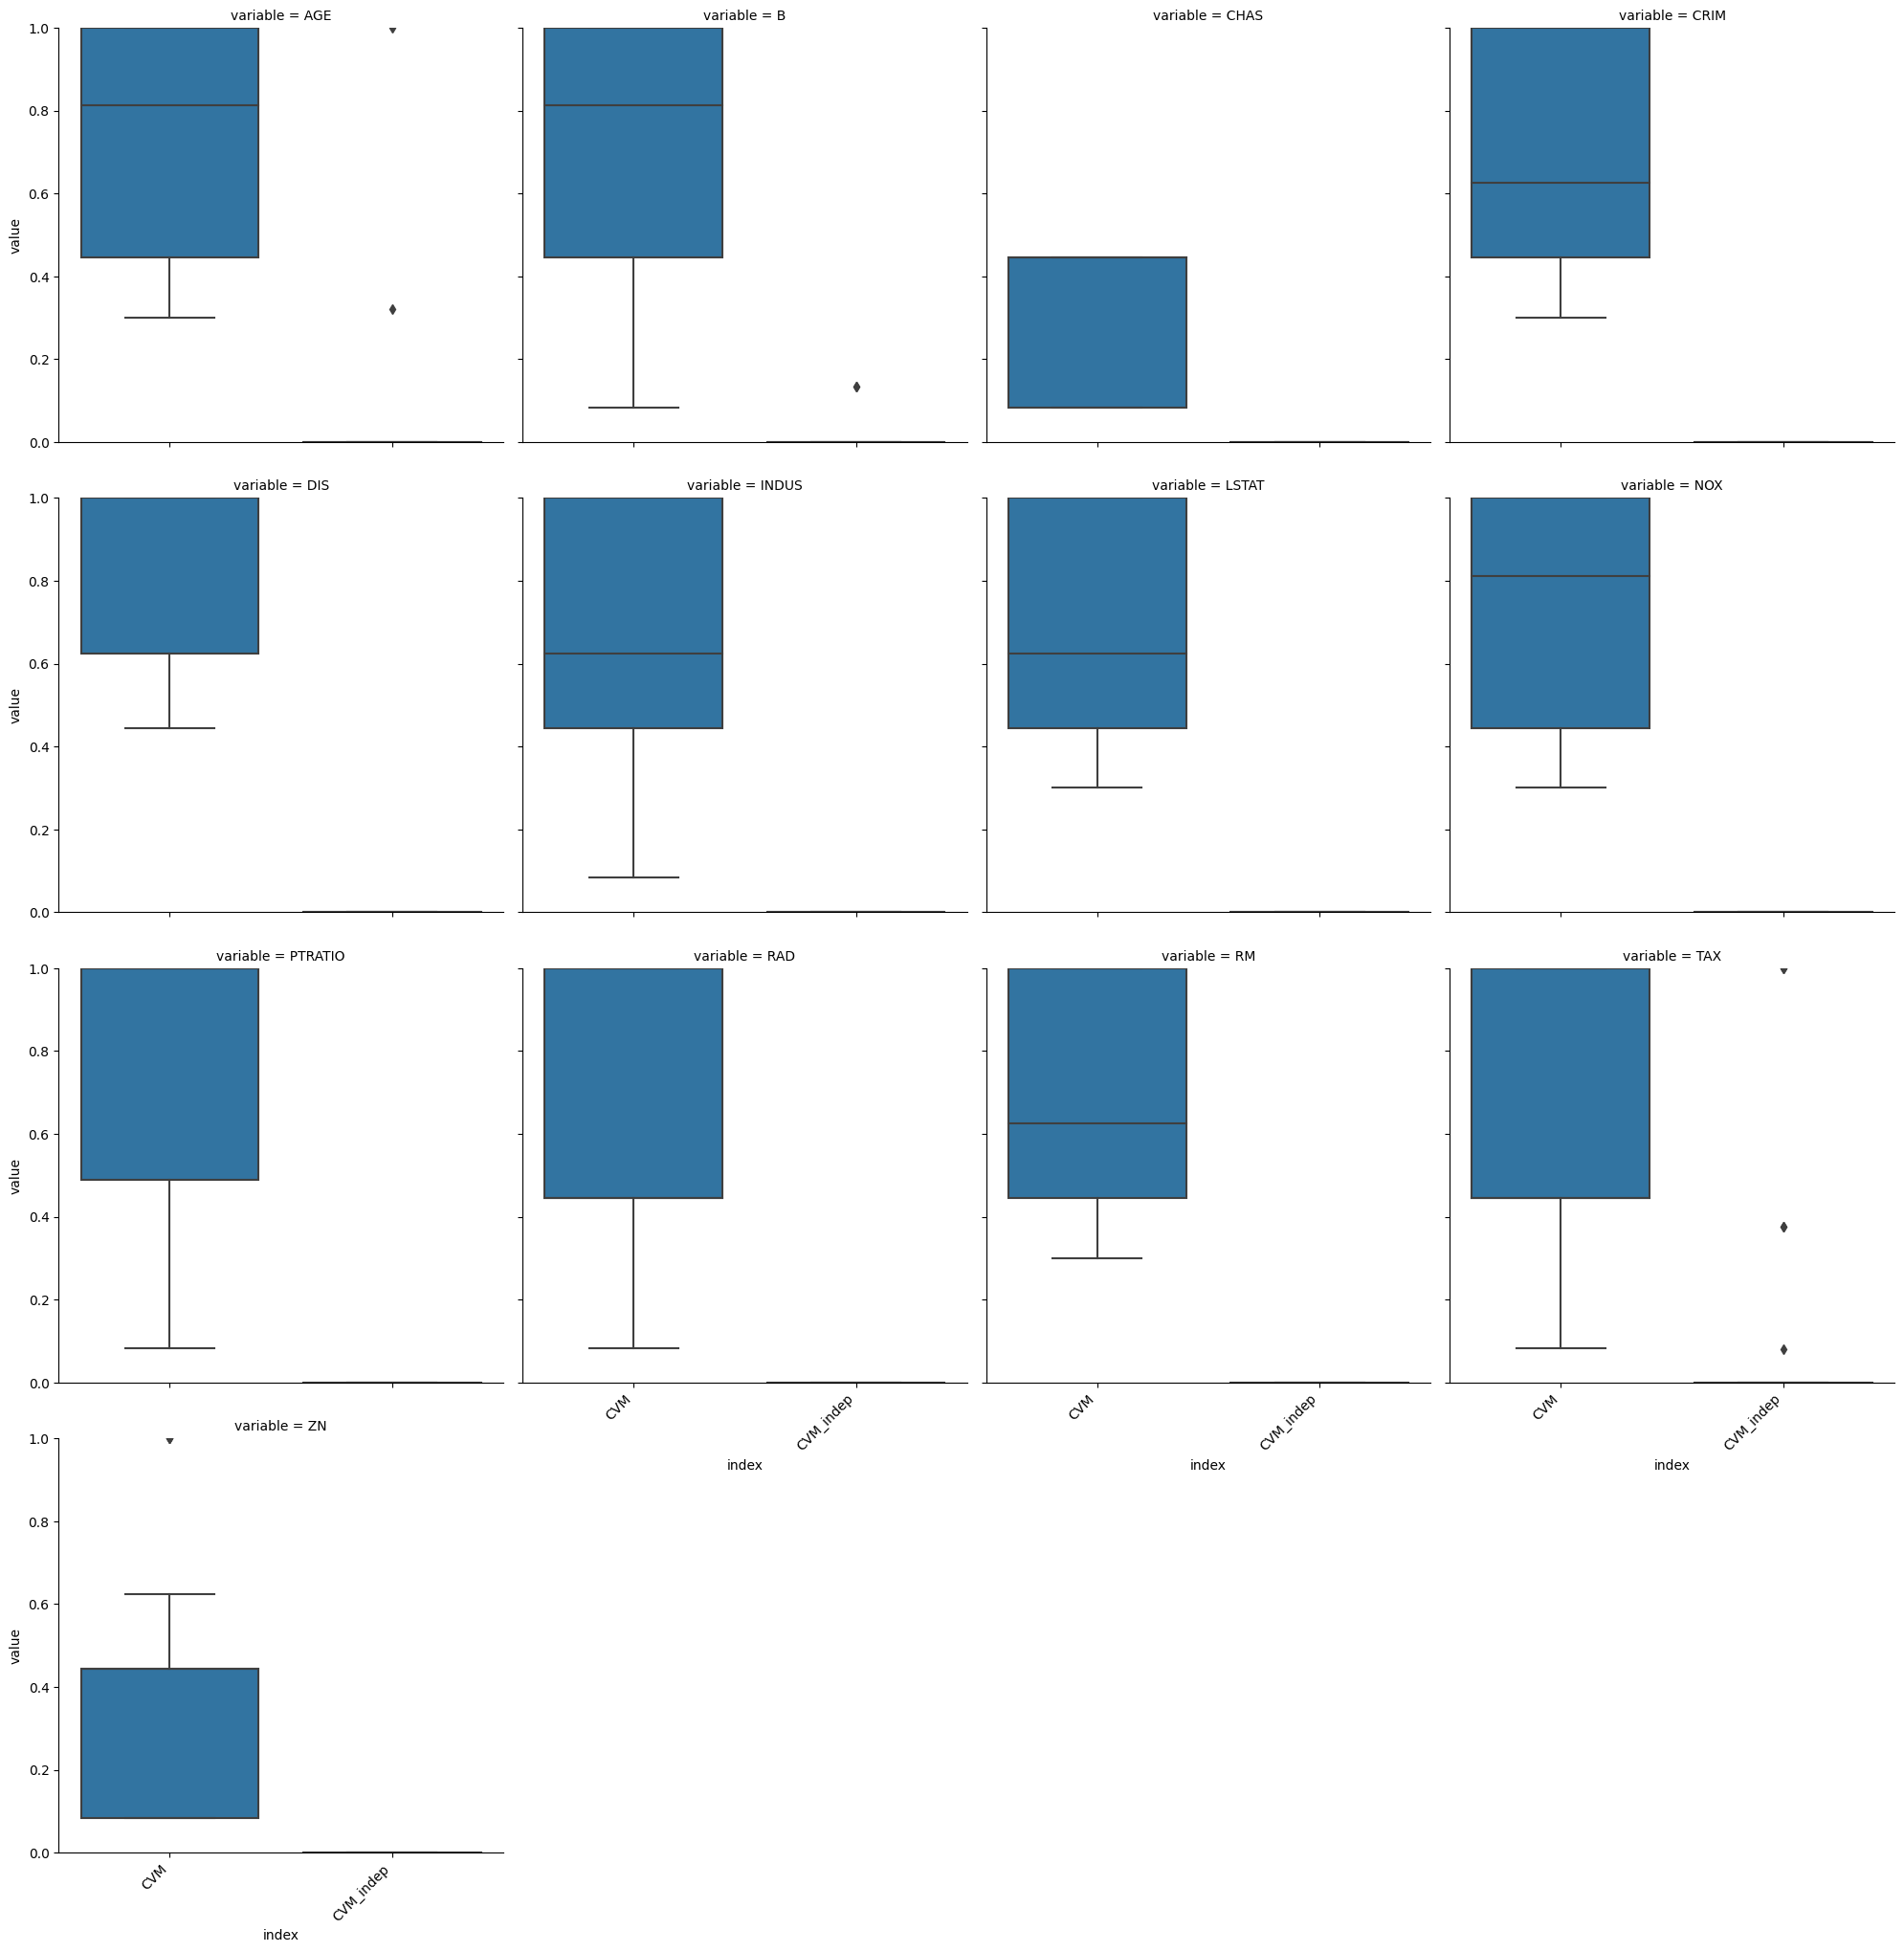

In [19]:
cat_plot(indices_outputs_error_test, plot_per="variable", kind="box", col_wrap=4)
plt.show()